In [758]:
#Define helper functions
function ptovPos(pos,Nmid,dcell)  # converts from physical to virtual units in position
    return (pos/dcell + float(Nmid)) # fractional position in vertual units
end

function vtopPos(pos,Nmid,dcell) # converts from virtual to physical units in position (natually placing the point at the center of a cell)
    return float((pos-Nmid))*dcell # returns the center of the cell in physical units
end

function ptovVel(vel,dv) # converts velocity to virtual units from physical units
    return vel/dv # units of cells/time step
end

function vtopVel(vel,dv) # converts velocity to physical units from virtual units
    return vel*dv # units of m/s
end

function solveFields(vf,ErDC,EzDC,ErAC,EzAC,Nrmid,Nzmid,Ni,dr,dz) # takes in particle positions in virtual units and spits out electric fields at all cells
    # vf is the vector of ion parameters
    # ErDC is the array of electric fields from the DC electrodes in r
    # EzDC is the array of electric fields from the DC electrodes in z
    # ErAC is the array of electric fields from the AC electrodes in r
    # EzAC is the array of electric fields from the AC electrodes in z
    # can improve this to replace the grid with E-fields by cell with a vector of E-fields by ion
    eps0 = 8.854e-12 #SI units 
    Erf2 = np.zeros(Ni)
    Ezf2 = np.zeros(Ni)
    for i=1:length(vf[:,1]) # note that this no longer takes the electric field from all particles, so chillax 
        jCell = convert(UInt32,round(vf[i,1])) # local cell index in r
        kCell = convert(UInt32,round(vf[i,2])) # local cell index in z
        Erf2[i] += ErDC[jCell,kCell] + ErAC[jCell,kCell]
        Ezf2[i] += EzDC[jCell,kCell] + EzAC[jCell,kCell]
        
        for j=1:length(vf[:,1])
            if j!=i #here we solve for the E-fields in this cell from the particles outside this cell
                rdist = (vf[j,1]-vf[i,1])*dr
                zdist = (vf[j,2]-vf[i,2])*dz
                sqDist = (rdist)^2 + (zdist)^2 #distance from particle to cell
                projR = rdist/sqDist^(1/2) #sin theta to project E field to r basis
                projZ = zdist/sqDist^(1/2) #cos theta to project E field to z basis
                
                Erf2[i] += -projR*vf[j,5]/(4*pi*eps0*sqDist) # add fields in r
                Ezf2[i] += -projZ*vf[j,5]/(4*pi*eps0*sqDist) # add fields in z 
            end
        end        
    end
        #println("Radial All Fields at axis on ion 1 = ",Erf2[convert(UInt32,Nrmid),convert(UInt32,round(vf[1,2]))])

    return Erf2,Ezf2
end

function ACFields(ErAC0,EzAC0,phaseAC,f,tstep,dt) # returns AC fields at each grid cell based on the amplitude at each cell, starting phase, and frequency
    return ErAC0.*sin.(phaseAC+tstep*dt),EzAC0.*sin.(phaseAC+tstep*dt)
end

function updateVels(vf,Erf,Ezf,dt,Nrmid,Nzmid,dr,dz,dvr,dvz) # apply the forces from the local electric field over one time step
    for i=1:length(vf[:,1]) 
        # apply E-field of the cell
        
        Fr = vf[i,5]*Erf[i]  # solve force 
        Fz = vf[i,5]*Ezf[i] 
        
        #then we would need to convert back to virtual units 
        vf[i,3] += ptovVel(Fr*dt/(vf[i,6]),dvr) # update velocity with F*t/m
        vf[i,4] += ptovVel(Fz*dt/(vf[i,6]),dvz)

    end
    return vf
end

function updatePoss(vf,dt,Nr,Nz) # move the particles one time step
    for i=1:length(vf[:,1]) 
        vf[i,1] += vf[i,3] # correct if virtual since one time step is passing
        vf[i,2] += vf[i,4]
        if vf[i,1]>Nr-1 || vf[i,1]<2
            println("Position out of simulation in r ",vf[i,1]," Particle # ",i," vf = ",vf[i,:])
            vf[i,:] = vf[i,:].*0.0
            vf[i,1] = 2.0
            vf[i,2] = 2.0
            vf[i,3] = 0.0
            vf[i,4] = 0.0
            vf[i,6] = 1e6
            
        elseif vf[i,2]>Nz-1 || vf[i,2]<2
            println("Position out of simulation in z ",vf[i,2]," Particle # ",i," vf = ",vf[i,:])
            vf[i,:] = vf[i,:].*0.0
            vf[i,1] = 2.0
            vf[i,2] = 2.0
            vf[i,3] = 0.0
            vf[i,4] = 0.0
            vf[i,6] = 1e6
        end
    end
    return vf
end

function makeRF0(m,q,w,Nr,Nz,Nrmid,dr) # dummy function to generate the RF field in our grid assuming that it is a harmonic potential about (0,0) and focuses in x
    # We take in the mass, frequency for that mass, cell numbers, midpoint, and physical width of a cell and output the RF electric fields (constant in z) as a function of radial cell
    C = -m*(w^2)/q
    RF = np.ones((Nr,Nz))
    for jCell=1:Nr
        RF[jCell,:] = -RF[jCell,:].*C*(Nrmid-jCell)*dr
    end
    return RF
end

function makeDC(m,q,w,Nz,Nr,Nzmid,dz) # dummy function to generate the DC fields assuming that it is a harmonic potential about (0,0) and focuses in z
    # We take in the mass, frequency for that mass, cell numbers, midpoint, and physical width of a cell and output the DC electric fields (constant in r) as a function of longitudinal cell
    C = -m*(w^2)/q
    DC = np.ones((Nr,Nz))
    for kCell=1:Nz
        DC[:,kCell] = -DC[:,kCell].*C*(Nzmid-kCell)*dz
        #println("value for row = ",C*(Nzmid-kCell)*dz)
    end
    return DC
end

function makeVField(m,q,wr,wz,Nr,Nz,Nrmid,Nzmid,dr,dz)
    # we assign voltage at each point given our trapping frequencies
    Cr = -0.5*m*(wr^2)/q
    Cz = -0.5*m*(wz^2)/q
    Vf = np.ones((Nr,Nz))
    for jCell=1:Nr
        for kCell=1:Nz
            Vf[jCell,kCell] = Cr*((Nrmid-jCell)*dr)^2 + Cz*((Nzmid-kCell)*dz)^2
        end
    end
    return Vf
end
    
function laserCool(vf,vl,I0,nul,dnul,nu0,A,T,Ni,dt,dvr,dvz) # this takes the particle population and applies a global laser cooling field coupled to the radial and axial velocities
    # vf is particle pop
    # vl is the laser propagation vector (vr,vz) normalized to 1
    # I0 is laser peak intensity
    # nul is the laser frequency (all frequencies are angular frequencies)
    # dnul is the laser width
    # nu0 is the transition frequency
    # we assume the laser comes in counter to the positive velocity direction
    # A is the einstein A coefficient which gives spontaneous transition rate
    # T is the natural decay lifetime
    hbar = 1.05e-34 #plancks constant in J*s
    c = 2.998e8 #speed of light in m/s
    dnul2 = 2*dnul^2 #removed from for loop to save calc time
    C0=dt*(pi*c^2/(2*nu0^2))/(hbar*nu0) # this is the stimulated emission cross-section with only natural broadening divided by the photon energy assuming all transitions are the desired ultra-fast one
    # I'm treating the transition frequency as I*B/c which is equivalent to I*sigma / photon energy
    pl = hbar*nu0/c # for the momentum of the laser
    norm = 2^-(1/2) # 1/root2 for the unit vector multiple
    
    for i=1:Ni
        vil = vf[i,3]*vl[1]+vf[i,4]*vl[2] #velocity of ion in laser propagation direction
        dopp = ((1+vil/c)/(1-vil/c))^(1/2) # the doppler shift assuming ion velocity is well below the speed of light
        nuInt = nu0/dopp # the doppler shifted ion transition frequency (really doppler shifts the laser) 
        abs0 = C0*I0*exp(-(nul-nuInt)^2/(dnul2))
        C1 = abs0*pl/vf[i,6] # fractional emitted photon velocity change
        vf[i,3] += vl[1]*C1*dopp/dvr # radial velocity reduction from absorption
        vf[i,4] += vl[2]*C1*dopp/dvz # axial velocity reduction from absorption
        theta = rand(Float64)*2*pi # make random vector angle
        remit = norm*sin(theta)
        zemit = norm*cos(theta)
        vf[i,3] -= remit*C1/dvr # radial velocity addition from emission
        vf[i,4] -= zemit*C1/dvz # axial velocity addition from emission
        if (remit*C1/dvr)^2 + (zemit*C1/dvz)^2 > (vl[1]*C1*dopp/dvr)^2 + (vl[2]*C1*dopp/dvz)^2
            println("radial emission = ",remit*C1/dvr)
            println("axial emission = ",zemit*C1/dvz)
            println("radial absorption = ",vl[1]*C1*dopp/dvr)
            println("axial absorption =", vl[2]*C1*dopp/dvz)
        end
    end
    return vf # we return the updated populations
end

function laserCoolSmooth(vf,vl,I0,nul,dnul,nu0,A,T,Ni,dt,dvr,dvz) # this takes the particle population and applies a global laser cooling field coupled to the radial and axial velocities that purely reduces the velocity like a true damping force
    # vf is particle pop
    # vl is the laser propagation vector (vr,vz) normalized to 1
    # I0 is laser peak intensity
    # nul is the laser frequency (all frequencies are angular frequencies)
    # dnul is the laser width
    # nu0 is the transition frequency
    # we assume the laser comes in counter to the positive velocity direction
    # A is the einstein A coefficient which gives spontaneous transition rate
    # T is the natural decay lifetime
    hbar = 1.05e-34 #plancks constant in J*s
    c = 2.998e8 #speed of light in m/s
    dnul2 = 2*dnul^2 #removed from for loop to save calc time
    C0=dt*(pi*c^2/(2*nu0^2))/(hbar*nu0) # this is the stimulated emission cross-section with only natural broadening divided by the photon energy assuming all transitions are the desired ultra-fast one
    # I'm treating the transition frequency as I*B/c which is equivalent to I*sigma / photon energy
    pl = hbar*nu0/c # for the momentum of the laser
    norm = 2^-(1/2) # 1/root2 for the unit vector multiple
    
    for i=1:Ni
        if vf[i,6]<1.0 #if the particle exists it should have a realistic mass
            vil = vf[i,3]*vl[1]+vf[i,4]*vl[2] #velocity of ion in laser propagation direction
            dopp = ((1+vil/c)/(1-vil/c))^(1/2) # the doppler shift assuming ion velocity is well below the speed of light
            nuInt = nu0/dopp # the doppler shifted ion transition frequency (really doppler shifts the laser) 
            abs0 = C0*I0*exp(-(nul-nuInt)^2/(dnul2))
            C1 = abs0*pl/vf[i,6] # fractional emitted photon velocity change
            dE = hbar*(nu0-nuInt)
            if dE>0
                #println("Cool ",dE)
                vf[i,3] -= vl[1]*abs0*(2*dE/vf[i,6])^(1/2)/dvr # radial velocity reduction from absorption
                vf[i,4] -= vl[2]*abs0*(2*dE/vf[i,6])^(1/2)/dvr # axial velocity reduction from absorption
            end
            if dE<=0
                #println("Heat ",dE)
                vf[i,3] += vl[1]*abs0*(-2*dE/vf[i,6])^(1/2)/dvr # radial velocity reduction from absorption
                vf[i,4] += vl[2]*abs0*(-2*dE/vf[i,6])^(1/2)/dvr # axial velocity reduction from absorption
            end
        end
    end
    return vf # we return the updated populations
end

function collisionParticlesFields(vf,vc,Ni,ErDC,EzDC,ErAC,EzAC,dr,dz,dvr,dvz,dt) # this applies the fields of all existing collisional particles and changes the velocity of those collisional particles
    # vf is the ion parameters in virtual units
    # vc is the collisional particle parameters in virtual units this probably should be a list of lists, but it's a static array right now
    # Ni is the number of ions
    # Erfi is the radial electric fields on ions
    # Ezfi is the axial electric fields on ions
    # Erfc is the radial electric fields on collisional particles at both pseudo-particle points
    # Ezfc is the axial electric fields on collisional particles at both pseudo-particle points
    # dr is the physical size of a cell in r
    # dz is the physical size of a cell in z
    # ErDC,EzDC,ErAC,EzAC are the electric fields from the background
    # note that we treat dipoles as if they instantly align with the electric field from monopoles

    Nc = length(vc[:,1])
    #println("Nc = ",Nc)
    # we begin by instantiating the electric field lists
    Erfi = np.zeros(Ni) # fields are in physical units
    Ezfi = np.zeros(Ni)
    Erfc = np.zeros((Nc,2)) # [i,1] is middle field, 2 is high index - low index
    Ezfc = np.zeros((Nc,2))
    
    sqDist = np.zeros((Nc,Ni))
    projR = np.zeros((Nc,Ni))
    projZ = np.zeros((Nc,Ni))
    # we solve the electric fields on the collisional particles
    for i=1:Nc # for each collisional particle that exists
        # In order to allow for electric field gradients of the background field, here we need to implement a linear E-field gradient between neighboring cells
        jCell = convert(UInt32,round(vc[i,1])) # local cell index in r for center point
        kCell = convert(UInt32,round(vc[i,2])) # local cell index in z for center point
        # we initialize the interpolated field for each 
        Erfc[i,1] += (ErDC[jCell,kCell] + ErAC[jCell,kCell])
        Ezfc[i,1] += (EzDC[jCell,kCell] + EzAC[jCell,kCell])
        Erfc[i,2] += ((ErDC[jCell+1,kCell] + ErAC[jCell+1,kCell])-(ErDC[jCell-1,kCell] + ErAC[jCell-1,kCell]))/dr
        Ezfc[i,2] += ((EzDC[jCell,kCell+1] + EzAC[jCell,kCell+1])-(EzDC[jCell,kCell-1] + EzAC[jCell,kCell-1]))/dz
        for j=1:Ni # solve the electric field exerted by each ion
            rdist = (vf[j,1]-vc[i,1])*dr
            zdist = (vf[j,2]-vc[i,2])*dz
            sqDist[i,j] = (rdist)^2 + (zdist)^2 #distance from particle to cell
            projR[i,j] = rdist/sqDist[i,j]^(1/2) #sin theta to project E field to r basis
            projZ[i,j] = zdist/sqDist[i,j]^(1/2) #cos theta to project E field to z basis
            
            Erfc[i,1] += -projR[i,j]*vf[j,5]/(4*pi*eps0*sqDist[i,j]) # add fields in r
            Ezfc[i,1] += -projZ[i,j]*vf[j,5]/(4*pi*eps0*sqDist[i,j]) # add fields in z   
            # I just need to add the gradient field from these now and the colliding particle should rebound
            Erfc[i,2] += 2*projR[i,j]*vf[j,5]/(4*pi*eps0*sqDist[i,j]^(3/2)) # add fields in r
            Ezfc[i,2] += 2*projZ[i,j]*vf[j,5]/(4*pi*eps0*sqDist[i,j]^(3/2)) # add fields in z             
        end
    end
    pR = np.zeros(Nc)
    pZ = np.zeros(Nc)
    pTot = np.zeros(Nc)
    for i=1:Nc    # a dipole is induced in the direction of the electric field vector with the positive pseudoparticle in the positive field direction
        if vc[i,7]!=0.0 # if there is a dipole moment that can be obtained
            pR[i] = -vc[i,7]*Erfc[i] # dipole in r in physical units
            pZ[i] = -vc[i,7]*Ezfc[i] # dipole in z in physical units
            pTot[i] = (pR[i]^2+pZ[i]^2)^(1/2) # total dipole length in physical units
            # we can now induce the force on the dipole


            Fr = abs(pR[i])*Erfc[i,2]
            Fz = abs(pZ[i])*Ezfc[i,2]
            #then we would need to convert back to virtual units once we apply the forces
            vc[i,3] += ptovVel(Fr*dt/(vc[i,6]),dvr) # update velocity with F*t/m
            vc[i,4] += ptovVel(Fz*dt/(vc[i,6]),dvz)                  
        end
    end
    
    # we then solve for the fields the collisional particles exert on the ions from the dipole (and quadrapole potentially) as well as the charge if the particle has one
    for i=1:Ni # for each ion in the trap
        for j=1:Nc # apply the field from each collisional particle
            # the dipole field is (3*(dipole moment dotted with vector from particle to ion)(in vector from particle to ion) - (dipole moment))/(3*pi*eps0*distance^3)
            # at close proximity, it should be treated as monopoles with charge qe separated by (dipole moment)/qe distance along the dipole moment vector
            # for now we treat the electric field it exerts as a pure dipole
            if vc[j,7]!=0.0 # if there is a potential dipole moment
                Rhatr = projR[j,i]
                Rhatz = projZ[j,i]

                dist = sqDist[j,i]^(1/2)
                #Erfi[i] += -abs(pR[j])*(3*Rhatr - 1)/(3*pi*eps0*dist^3) # add dipole fields
                #Ezfi[i] += -abs(pZ[j])*(3*Rhatz - 1)/(3*pi*eps0*dist^3)
                Erfi[i] += -abs(pR[j])*(2*Rhatr)/(4*pi*eps0*dist^3) # add dipole fields
                Ezfi[i] += -abs(pZ[j])*(2*Rhatz)/(4*pi*eps0*dist^3)
            end
            #println("Erfi = ",Erfi[i]);println("Ezfi = ",Ezfi[i]);println("dist = ",dist)
            #println("Rhatr = ",Rhatr);println("Rhatz = ",Rhatz);println("Nc = ",Nc)
        end
    end
    
    return vc,Erfi,Ezfi,Erfc,Ezfc # the ion electric fields are just from the collisional particles, the collisional electric fields are from all sources
end # note that I haven't applied electric fields from collisional particles onto each other

function makeVf(Ni,q,m,l,dsepz,offsetr,offsetz,vbumpr,vbumpz)
    vf = np.zeros((Ni,7))
    Nimid = (Ni+1)/2.0
    for i=1:Ni
        vf[i,:] = [Nrmid,Nzmid+(Nimid-i)*dsepz,0,0,q,m,0.0]
    end
    vf[l,1] += offsetr
    vf[l,2] += offsetz
    vf[l,3] += vbumpr
    vf[l,4] += vbumpz
    return vf
end


function monteCarloCollisionParticles(vc,P,T,Vf,sigmaV,dt,dv,vmax,Nr,Nz,dr,dz)
    # This will initialize collisional particles following a modifice Boltzmann distribution at the outer edges
    # of the simulation frame with velocity dependent cross-section, and the reduced energy from climbing to the top 
    # of the trapping potential well
    # We assume the particle approach to go up a gaussian potential with sigmaV for its sigma
    # this sigma is increased if we approach at a glancing angle (not added yet)
    # This means we don't account for deflection incurred by irregularly shaped potentials
    # We also don't account for directional outgassing from surfaces
    # vc is the collisional particle vector, uninitialized particles have zeros for all their non-position parameters
    # P is the pressure in Pa
    # T is the temperature in Kelvin
    # Vf is the array of potentials in each cell of the sim
    # sigmaV is how steep the slope of the voltage outside of the peak is (approximating the shape as half a gaussian)
    # dt is the size of the time step in s (used to determine if there is a collision)
    # dv is the bin size of the speed dependent functions in this routine
    # vmax is the highest velocity to check for
    # Nr and Nz are the number of cells in each dimension
    # dr and dz are the physical size of those cells in m
    # currently we assume all collisional particles are molecular hydrogen
    
    #q = 1.602e-19 # define the constants
    m = 2.0*1.66e-27
    a = 8e-31  
            #        # Adjust speed for the trapping potential peak
            #        if vc[i,5]>0.0 #if we have an ion
            #            dv = -(2*q*Vpeak/m)^(1/2)
            #        end
            #        elseif vc[i,7]>0.0 #if we have a dipole
            #dv = pi^(1/4)*Vpeak*(a/(2*m*sigmaV))^(1/2) # get the reduction in velocity from the shape of the trapping potential
            #        end
    k = 1.38e-23 # boltzmann constant in SI units
    f0 = P/(k*T) # collision frequency without cross section, velocity, or distribution
    Dr = Nr*dr # physical sim size in r
    Dz = Nz*dz # physical sim size in z
    Nv = convert(UInt32,round(vmax/dv)) # number of velocity bins
    
    
    # next we map out the collision frequency as a function of velocity 
    sigmaTB(vr,vz)=Dr*Dz*(Dr*vz/(Dr*vz + Dz*vr)) # cross section for the top/bottom as a function of velocities vr/vz can be replaced by sin(phi)/cos(phi)
    sigmaLR(vr,vz)=(Dr^2)*(pi/4)*(Dz*vr/(Dr*vz + Dz*vr)) # cross section for the left/right as a function of velocities
    g(v,delta,m) = (m/(k*T))*(v-delta)*exp(-m*(v-delta)^2/(2*k*T)) # this sets the shape of the velocity distribution (normalized to 1)
    
    # then we find out if a particle should be added in this timestep
    exists = rand(Float64,Nv)
    phi = rand(Float64)*2*pi # Pick a particle angle
    vr = sin(phi) # set relative r and z velocities
    vz = cos(phi)
    vrpos = abs(vr) #explicitly positive values for cross-sections or ratios
    vzpos = abs(vz)
    r = convert(UInt32,round(rand(Float64)*(Nz-3) +2)) #note that for the potential field at our boundary, we assume symmetry about the midpoint on each dimension
    z = convert(UInt32,round(rand(Float64)*(Nz-3) +2))
    deltaTB = -pi^(1/4)*Vf[2,z]*(a/(2*m*sigmaV/vrpos))^(1/2) #speed reduction due to potential shape and angle of approach
    deltaLR = -pi^(1/4)*Vf[r,2]*(a/(2*m*sigmaV/vzpos))^(1/2)
    minI = max(1,convert(UInt32,round(min(deltaTB,deltaLR)/dv))) #don't bother checking for a collision under our minimum speed set by the speed reduction

    if minI>=Nv-1
        println("No collisional particles could make it over the escape point this time")
        return vc
    end
    
    coll=0 #for no particle
    speed = 0.0
    #Debug
    #println("minI = ",minI)
    #println("f0 = ",f0)
    #println("deltaTB = ",deltaTB)
    #println("deltaLR = ",deltaLR)
    #println("sigma = ",sigmaTB(vrpos,vzpos)+sigmaLR(vrpos,vzpos))
    #println("Dr = ",Dr)
    #println("Dz = ",Dz)
    #println("dt = ",dt)
    ftot=0.0
    for i=minI:Nv
        #aboveThresh = 1.0
        speed = dv*i
        fTB = f0*sigmaTB(vrpos,vzpos)*speed*g(speed,deltaTB,m)*dt*dv #probability of a collision in this stime step on top/bottom in this velocity bin
        fLR = f0*sigmaLR(vrpos,vzpos)*speed*g(speed,deltaLR,m)*dt*dv #probability of a collision in this stime step on left/right in this velocity bin
        ftot+=(fTB+fLR)
        #Debug
        #println("speed = ",speed)
        #println("g = ",g(speed,max(deltaTB,deltaLR),m))
        #print("123")
        #if exists[i]<fTB+fLR
        #    println("should collide")
        #    println("fTB = ",fTB)
        #    println("fLR = ",fLR)
        #    println("exists[i] = ",exists[i])
        #end

        if exists[i]<fTB #if we get a particle to top/bottom
            if vr>0.0
                r = 2
                coll = 1 # 1 for bottom collisional particle
            else
                r = Nr-1
                coll = 2 # 2 for top collisional particle
            end
        elseif exists[i]<(fLR+fTB) # if we get a particle to left/right
            if vz>0.0
                z = 2
                coll=3 # 3 for left side
            else
                z = Nz-1
                coll=4 # 4 for right side
            end
        end
        #println("speed = ",speed)
    end
    
    if ftot>1.0
        println("Monte Carlo Error: Multiple collisions this cycle")
    end
    #Debug
    #println("ftot = ",ftot)
    #println("in MonteCarlo vc = ",vc)
    #println("coll = ",coll)
    if coll>0
        for i=1:length(vc[:,1]) #for each particle
            if vc[i,6]>1.0 #if that particle is free it's assigned a large mass customarily
                vc[i,:]= [r,z,vr*speed*dt/dr,vz*speed*dt/dr,0.0,m,a]
                #println("in MonteCarlo r = ",r)
                #println("in MonteCarlo z = ",z)
                return vc
            end
        end
        println("No free collisional particle slots, vc = ",vc)
    end
    return vc
end

function particleE(vr,vz,m)
    # takes in velocities and mass and returns energy
    return (1/2)m*(vr^2 + vz^2)
end

function particleP(v,m)
    # takes in velocity and mass and returns momentum
    return m*v
end

function totalEandP(vrs,vzs,ms)
    # takes in vectors of velocities and masses and returns total energy and momenta
    En = 0.0
    pr = 0.0
    pz = 0.0
    for i=1:length(vrs)
        En+=particleE(vrs[i],vzs[i],ms[i])
        pr+=particleP(vrs[i],ms[i])
        pz+=particleP(vzs[i],ms[i])
        println("pz = ",pz)
    end
    return [En,pr,pz]
end


totalEandP (generic function with 1 method)

In [781]:
# Set up trapping fields
using Statistics,PyCall,PyPlot
np = pyimport("numpy")

# Define useful constants
amu = 1.67e-27 #amu to kg
eps0 = 8.854e-12 #SI units 
qe = 1.6e-19 #Coulombs

# Define physical params
m = 40. *amu
q = 1. *qe
wr = 2*pi*3e6
wz = 2*pi*1e6


# Define sim params
Nz = 10001 # number of cells along trapping axis needs to be odd to allow null line
Nr = 10001 # number of cells perpendicular to trapping axis needs to be odd to allow null line
Nzmid = (Nz-1)/2 # middle cell which exists at z=0 in physical units
Nrmid = (Nr-1)/2 # middle cell which exists at r=0 in physical units

Dz = Nz*3e-9 # physical width in m of the sim in z
Dr = Nr*3e-9 # physical width in m of the sim in r
dr = Dr/float(Nr) # width of a cell in r in m
dz = Dz/float(Nz) # width of a cell in z in m

Erf = np.zeros((Nr, Nz)) # array of electric fields in r always physical units
Ezf = np.zeros((Nr, Nz)) # array of electric fields in z

# Here we'll do a demo for the motion of the particles in a linear trap
# Step one is make the DC and RF (pseudo)potentials

RF = makeRF0(m,q,wr,Nr,Nz,Nrmid,dr)
DC = makeDC(m,q,wz,Nz,Nr,Nzmid,dz)
Vfield = makeVField(m,q,wr,wz,Nr,Nz,Nrmid,Nzmid,dr,dz) # we add a matrix of the potential energy through our trap

nullFields = np.zeros((Nr,Nz))
# Test potential
#println("DC mid ", DC[Int64(round(Nrmid)),Int64(round(Nzmid))])
#println("DC top ", DC[1,1])
#println("DC bot ", DC[Nr,Nz])

#println("RF mid ", RF[Int64(round(Nrmid)),Int64(round(Nzmid))])
#println("RF top ", RF[1,1])
#println("RF bot ", RF[Nr,Nz])
println("constants set and modules imported")
println("Simulation Size = ",Dr,"m in r x ",Dz,"m in z")

constants set and modules imported
Simulation Size = 3.0003e-5m in r x 3.0003e-5m in z


In [795]:
# Set up other constants

Ni = 5 # number of trapped ions
vf = np.zeros((Ni, 6)) # array of r,z,vr,vz,q,m for each ion in virtual units
# Here we describe how the collisional particles work
# they are a list of lists where the first index is the particle identifier
# the second index gives r,z,vr,vz,q,m,a (dipole moment)
aH2 = 8e-31 # dipole moment of H2 in SI units
mH2 = 2.0*amu # mass of H2 in kg

#Nt = 130000 # number of time steps to take
Nt = 50000 # number of time steps to take
dt = 0.03e-9 # length of a time step in s
Dt = dt*Nt

dvr = dr/dt # velocity to move one cell in one time unit in r in m/s
dvz = dz/dt # velocity to move one cell in one time unit in z in m/s

# Now we add ions
l = 1
dsepz = 800 # starting separation between ions in virtual units
vbumpr = 0 # starting velocity in r of the lth ion in the chain
vbumpz = 0 # starting velocity in z of the lth ion in the chain
offsetz = 0 # starting distance from eq. in z of the lth ion in the chain
offsetr = 0 # starting distance from eq. in r of the lth ion in the chain

vf = makeVf(Ni,q,m,l,dsepz,offsetr,offsetz,vbumpr,vbumpz)
#println("vf = ",vf)

# add collisional particle list
Nc = 7
#vc = np.zeros((Nc,10))
#vc[1,:] = [3000,Nzmid-1100,0.0,0,0,mH2,aH2,0.0,0.0,0.0] # r,z,vr,vz,q,m,polarizability, dipole x, dipole z,spin rate in rads/s in tan^-1(r/z)
#vc[2,:] = [1000,Nzmid,0.0,0,0,mH2,aH2,0.0,0.0,0.0] 
vc = np.zeros((Nc,7))
vc[:,6] .= 1e6
#bimpact = 60
#speedimpact = 1500
#vc[1,:] = [Nrmid+bimpact,Nzmid-speedimpact//5,0.0,speedimpact/dvz,0,mH2,aH2] # r,z,vr,vz,q,m,polarizability, dipole x, dipole z,spin rate in rads/s in tan^-1(r/z)
#vc[1,:] = [Nrmid-100,Nzmid-200,1500/dvr,1500/dvz,0,mH2,aH2] # r,z,vr,vz,q,m,polarizability, dipole x, dipole z,spin rate in rads/s in tan^-1(r/z)
#vc[1,:] = [Nrmid + 60,3,0,1500/dvz,0,mH2,aH2] # r,z,vr,vz,q,m,polarizability, dipole x, dipole z,spin rate in rads/s in tan^-1(r/z)
vc[1:end,1] .+= 2
vc[1:end,2] .+= 2
# We assign values for the laser cooling
c = 2.998e8 #speed of light in m/s
nu0 = 2*pi*c/729e-9 # atomic transition frequency
vl = [2^-(1/2),2^-(1/2)] #laser direction unit vector in r and z
#vl = [0.0,1.0] #laser strictly axial
I0 = 2e-2/(pi*0.5e-3^2) #laser intensity in W/m^2 I've used 20 mW in a 1mm diameter circle
nul = (1.0-1e-6)*nu0 # laser center frequency
dnul = 1e-6*nu0# laser frequency width
A = 1.75e7 # einstein A coefficient for transition I've used the Nist table at 397.37nm
Ti = 1e-9 # transition lifetime
println("This simulation has a timestep of ",dt,"s and a duration of ",Dt,"s")
println("This simulation has a velocity resolution of ",dvr,"m/s radially and ",dvz,"m/s axially")

This simulation has a timestep of 3.0e-11s and a duration of 1.5e-6s
This simulation has a velocity resolution of 100.0m/s radially and 100.0m/s axially


In [796]:
# Now we push the ions about and track their positions
zs = np.zeros((Ni,Nt))
zmeans = np.zeros(Nt)
rs = np.zeros((Ni,Nt))
rmeans = np.zeros(Nt)
vrs = np.zeros((Ni,Nt))
vzs = np.zeros((Ni,Nt))
aveSpeeds = np.zeros((2,Nt))
rcolls = np.zeros((Nc,Nt))
zcolls = np.zeros((Nc,Nt))
vrcolls = np.zeros((Nc,Nt))
vzcolls = np.zeros((Nc,Nt))

P = 3e-7 # pressure in pascals or multiply by 1e-2mbar/Pa
T = 300 # temperature in kelvin
sigmaV = 100e-6 # fall-off of potential outside trapping region
dv = 20.0 # bin size for particle speed in determining if collision occurs
vmax = 5000 # maximum particle speed we allow

#for testing
#DC = DC.*0.0
#RF = RF.*0.0

for i=1:Nt
    #println("Time step ",i)
    #println("vf ",vf)
    #println("monteCarloTime")
    #println("vc = ",vc)
    #vc = monteCarloCollisionParticles(vc,P,T,Vfield,sigmaV,dt,dv,vmax,Nr,Nz,dr,dz)
    #println("vc = ",vc)
    #println("solveFields")
    Erfi,Ezfi = solveFields(vf,nullFields,DC,RF,nullFields,Nrmid,Nzmid,Ni,dr,dz) # solve fields from ions on ions
    if sum(vc[:,6])<1e6*Nc
        #println("vc[:,6] = ",vc[:,6])
        #println("Time step ",i)
        vc,Erfic,Ezfic,Erfc,Ezfc = collisionParticlesFields(vf,vc,Ni,nullFields,DC,RF,nullFields,dr,dz,dvr,dvz,dt) # solve fields from ions on collision particles and vice versa
        vc = updatePoss(vc,dt,Nr,Nz)
        Erfi += Erfic # add the collisional fields
        Ezfi += Ezfic
    end
    #println("updateVels")
    #println("vc after fields = ",vc);println("Erfc = ",Erfc);println("Ezfc = ",Ezfc);println("vc[1] = ",vc[1])
    vf = updateVels(vf,Erfi,Ezfi,dt,Nrmid,Nzmid,dr,dz,dvr,dvz)
    #println("vc after vels = ",vc);println("vf1 ",vf);println("Erfi at middle radius = ",Erfi[convert(UInt32,Nrmid),convert(UInt32,round(vf[1,2]))]);println("Ezfi at middle radius = ",Ezfi[convert(UInt32,Nrmid),convert(UInt32,round(vf[1,2]))])
    #println("updatePoss")
    vf = updatePoss(vf,dt,Nr,Nz)
    #println("vc after Poss = ",vc)
    #println("laserCool")
    if any(isnan, vf)
        println("NaN detected in ion parameters before laserCool!!")
        println("vf = ",vf)
        println("i = ",i)
        testr = convert(UInt32,round(vf[1,1]))
        testz = convert(UInt32,round(vf[1,2]))
        println("Efields = ",Erfi," , ",Ezfi)
    end
    vf = laserCoolSmooth(vf,vl,I0,nul,dnul,nu0,A,Ti,Ni,dt,dvr,dvz)
    #println("vf2 ",vf)
    rs[:,i]=vf[:,1]
    rcolls[:,i]=vc[:,1]
    #rmeans[i] = mean(vf[:,1])
    zs[:,i]=vf[:,2]
    zcolls[:,i]=vc[:,2]
    #zmeans[i] = mean(vf[:,2])
    vrs[:,i]=vf[:,3]
    vzs[:,i]=vf[:,4]
    vrcolls[:,i]=vc[:,3]
    vzcolls[:,i]=vc[:,4]
    #if mod(i,500)==0
    #    println("vf = ",vf)
    #end
    if any(isnan, vf)
        println("NaN detected in ion parameters after laserCool!!")
        println("vf = ",vf)
        println("i = ",i)
        testr = convert(UInt32,round(vf[1,1]))
        testz = convert(UInt32,round(vf[1,2]))
        println("Efields = ",Erfi," , ",Ezfi)
    end
    for j=1:Ni
        aveSpeeds[1,i] += vf[j,3]^2
        aveSpeeds[2,i] += vf[j,4]^2
    end
end

# I still need to update the velocity and position of the collision particles
# I think the current problem is that I need to allow for the dipole moment 
# to be misaligned to the electric fields when applying the forces
# this means I'll need to account for the torque applied to the dipole
#
# the other things I need to work in before moving to 3d are as follows:
# 1) Find out what E-field gradient breaks the molecular bond of H2 (4.74 eV)and print statements when that happens
# 2) Incorporate 2 or 3 other collisional species (maybe O2 and H20)
# 3) Build Monte Carlo system for introducing more colliding particles
# 
# Regarding #1: 4.74V = DeltaV(between dipole ends) ~ EField(mid)*dipoleDistance
# if this split were to occur, I hypothesize that we would have one each H- and H+
# the H- would naturally eject itself from the trap or donate an electron to one of the ions?
# the H+ would behave similar to previously except it is now an electric monopole
#
# Regarding #0: I'll need to add dipole separation in r and z to the vc params [8] and [9] respectively. 
# This will allow me to calculate the torque and force as well as separate the dipole solver from the velocity pusher
# This would also be a good time to add in some better function separation to clarify the code better
#
# My doppler cooling is a little off as I haven't accounted for the lineshape of the transition. 
# Currently it is dominated by the lineshape of the laser which is true for the case I coded, but maybe not true generally

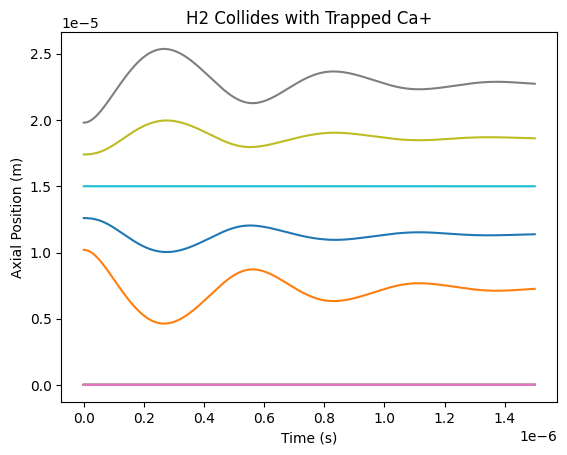

In [797]:
# Now we plot their positions over time
first = 1
#first = convert(UInt32,Nt/2)
#first = 280
last = Nt
#last = convert(UInt32,1*Nt/40)
#last = 390
title1 = "H2 Collides with Trapped Ca+"
for i=1:Nc
    plot(dt.*range(first,last),dz.*zcolls[i,first:last])
end
for i=1:Ni
    plot(dt.*range(first,last),dz.*zs[i,first:last])
end

xlabel("Time (s)")
ylabel("Axial Position (m)")
title(title1)


show()

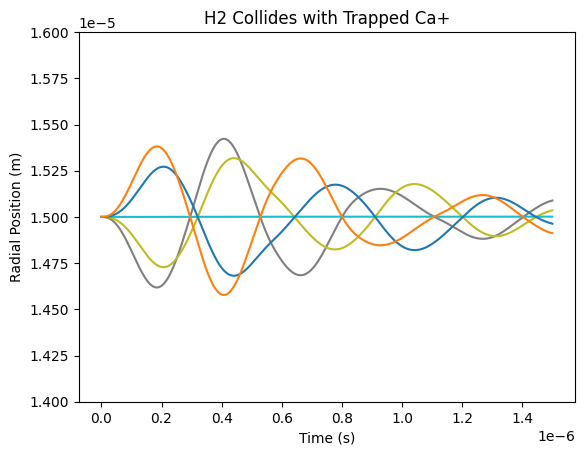

In [803]:
for i=1:Nc
    plot(dt.*range(first,last),dr.*rcolls[i,first:last])
end
for i=1:Ni
    plot(dt.*range(first,last),dr.*rs[i,first:last])
end

xlabel("Time (s)")
ylabel("Radial Position (m)")
title(title1)

ax = gca()
# add new limits from 0 - 100
#ax[:set_xlim]([1.3e-5,1.7e-5])
ax[:set_ylim]([1.4e-5,1.6e-5])
show()

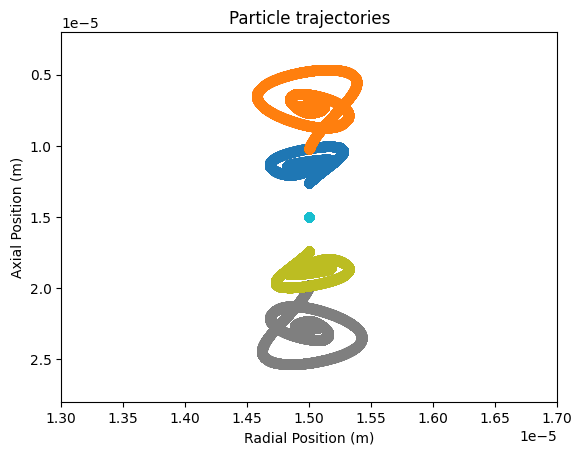

In [805]:
for i=1:Nc
    scatter(dr.*rcolls[i,first:last],dz.*zcolls[i,first:last])
end
for i=1:Ni
    scatter(dr.*rs[i,first:last],dz.*zs[i,first:last])
end

xlabel("Radial Position (m)")
ylabel("Axial Position (m)")
title("Particle trajectories")

ax = gca()
# add new limits from 0 - 100
ax[:set_xlim]([1.3e-5,1.7e-5])
ax[:set_ylim]([2.8e-5,0.2e-5])
show()

Initial velocity Ca+ = 0.019804326834179986
Final velocity Ca+ = -1.3901705361121917
Initial velocity H2 = 0.0
Final velocity H2 = 0.0
pz1 = 5.01e-24
pz2 = 5.010000000000001e-24
pr1 = 0.0
pr2 = -1.4693679385278594e-39
Fractional Energy Gain = 0.0025153912641507794
Radial momenta Gain (normalized to H2 at 1cell per unit time)= -4.399305205173232e-15
Axial momenta Gain (normalized to H2 at 1cell per unit time)= 2.199652602586616e-15


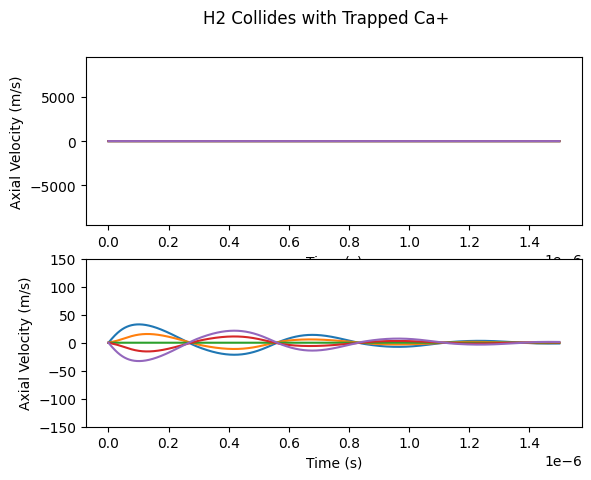

In [800]:
subplot(211)
for i=1:Ni
    plot(dt.*range(first,last),dvz.*vzcolls[i,first:last])
end
xlabel("Time (s)")
ylabel("Axial Velocity (m/s)")
#title(title1)
ax = gca()
# add new limits from 0 - 100
#ax[:set_xlim]([1.3e-5,1.7e-5])
ax[:set_ylim]([-9.5e3,9.5e3])
show()
subplot(212)
for i=1:Ni
    plot(dt.*range(first,last),dvz.*vzs[i,first:last])
end





xlabel("Time (s)")
ylabel("Axial Velocity (m/s)")
suptitle(title1)
ax = gca()
# add new limits from 0 - 100
#ax[:set_xlim]([1.3e-5,1.7e-5])
ax[:set_ylim]([-1.5e2,1.5e2])
show()

println("Initial velocity Ca+ = ",dvz.*vzs[1,first])
println("Final velocity Ca+ = ",dvz.*vzs[1,last])
println("Initial velocity H2 = ",dvz.*vzcolls[1,first])
println("Final velocity H2 = ",dvz.*vzcolls[1,last])

#Eprpz = totalEandP(dvr.*vrs[:,first],dvz.*vzs[:,first],m)
#Eprpz .+= totalEandP(dvr.*vrcolls[:,first],dvz.*vzcolls[:,first],mH2)
#E1 = Eprpz[1];pr1 = Eprpz[2];pz1 = Eprpz[3]
#Eprpz = totalEandP(dvr.*vrs[:,last],dvz.*vzs[:,last],m)
#Eprpz .+= totalEandP(dvr.*vrcolls[:,last],dvz.*vzcolls[:,last],mH2)
#E2 = Eprpz[1];pr2 = Eprpz[2];pz2 = Eprpz[3]
println("pz1 = ",pz1);println("pz2 = ",pz2);println("pr1 = ",pr1);println("pr2 = ",pr2)

println("Fractional Energy Gain = ",(E2-E1)/max(E1,E2),"\nRadial momenta Gain (normalized to H2 at 1cell per unit time)= ",(pr2-pr1)/(mH2*dvr),"\nAxial momenta Gain (normalized to H2 at 1cell per unit time)= ",(pz2-pz1)/(mH2*dvz) )


Initial velocity Ca+ = -4.980298393603691e-5
Final velocity Ca+ = 0.38230057279851076
Initial velocity H2 = 0.0
Final velocity H2 = 0.0


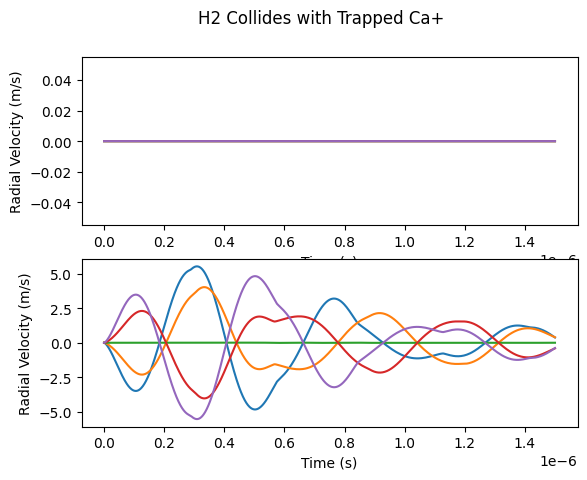

In [801]:
subplot(211)

for i=1:Ni
    plot(dt.*range(first,last),dvr.*vrcolls[i,first:last])
end
xlabel("Time (s)")
ylabel("Radial Velocity (m/s)")

subplot(212)

for i=1:Ni
    plot(dt.*range(first,last),dvr.*vrs[i,first:last])
end
xlabel("Time (s)")
ylabel("Radial Velocity (m/s)")
suptitle(title1)
show()
println("Initial velocity Ca+ = ",dvr.*vrs[1,first])
println("Final velocity Ca+ = ",dvr.*vrs[1,last])
println("Initial velocity H2 = ",dvr.*vrcolls[1,first])
println("Final velocity H2 = ",dvr.*vrcolls[1,last])

In [727]:
# this cell was originally at least intended to check that our doppler cooling approached the doppler limit. It would appear so
first = 4600
gamma = 1e6
kB = 1.38e-23
hbar = 1.05e-34 #plancks constant in J*s
println("1cell/1time (m/s) = ",dz/dt)
doppLimit = (hbar*gamma)/(2*m)
println("Doppler Limit (physical units) = ",doppLimit)
println("Doppler Limit (virtual units) = ",doppLimit/(dvz^2))
println("dvz = ",dvz)
println("1 quanta axial = ",hbar*wz)
println("1 quanta axial square speed (physical units) = ",2*hbar*wz/m)
println("1 quanta radial = ",hbar*wr)
println("1 quanta radial square speed (physical units) = ",2*hbar*wr/m)
plot(aveSpeeds[1,first:last])
#plot(aveSpeeds[2,first:last])
plot(np.ones(last-first)*doppLimit/(dvz^2))
title("Average square speed of all ions")
show()

1cell/1time (m/s) = 1000.0
Doppler Limit (physical units) = 0.0007859281437125748
Doppler Limit (virtual units) = 7.859281437125748e-10
dvz = 1000.0
1 quanta axial = 6.5973445725385655e-28
1 quanta axial square speed (physical units) = 0.019752528660295105
1 quanta radial = 6.597344572538566e-27
1 quanta radial square speed (physical units) = 0.19752528660295104


LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/bowers_b1/.julia/packages/PyCall/twYvK/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('negative dimensions are not allowed')
  File "/home/bowers_b1/.local/lib/python3.8/site-packages/numpy/core/numeric.py", line 192, in ones
    a = empty(shape, dtype, order)


In [185]:
hbar = 1.05e-34 #plancks constant in J*s
c = 2.998e8 #speed of light in m/s
hbar*nu0/(c*m)

0.013547687695675652

In [29]:
println("speed to cover whole sim in one time step = ",Dr/dt)

speed to cover whole sim in one time step = 1.0001e6


In [149]:
print(vf)

[NaN NaN NaN NaN 0.0 0.0 0.0]

In [719]:
println(bimpact*dr)
println(speedimpact)

1.8e-7
1500
